## XGBoost

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import multiprocessing
import numpy as np
import pandas as pd
from scipy import interp
from patsy import dmatrices
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import xgboost as xgb

In [2]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


In [3]:
def getDayOfYear(month, day): # ex. month = "mar", day = 15
    return int(datetime.datetime.strptime("{} {}".format(month, day), '%b %d').date().strftime('%j'))

train_df['dayofyear'] = np.vectorize(getDayOfYear)(train_df['month'], train_df['day'])
train_df['dayofweek'] = train_df['dayofyear'] % 7

In [4]:
def getPDayOfWeek(pdays):
    return -1 if pdays == -1 else pdays % 7

train_df['pdayofweek'] = np.vectorize(getPDayOfWeek)(train_df['pdays'])

In [5]:
# 質的変数をダミー変数化
y, X = dmatrices('y ~ age + job + marital + education + default + balance + housing + loan + contact + day + month + dayofyear + dayofweek + duration + campaign + pdays + pdayofweek + previous + poutcome', data=train_df, return_type='dataframe')
X_ = X.values
y_ = y.y.values

X.head()

,Intercept,job[T.blue-collar],job[T.entrepreneur],job[T.housemaid],job[T.management],job[T.retired],job[T.self-employed],job[T.services],job[T.student],job[T.technician],...,age,balance,day,dayofyear,dayofweek,duration,campaign,pdays,pdayofweek,previous
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.0,1756.0,3.0,93.0,2.0,939.0,1.0,-1.0,-1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.0,1443.0,18.0,49.0,0.0,172.0,10.0,-1.0,-1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,36.0,436.0,13.0,103.0,5.0,567.0,1.0,595.0,0.0,2.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,63.0,474.0,25.0,25.0,4.0,423.0,1.0,-1.0,-1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,31.0,354.0,30.0,120.0,1.0,502.0,1.0,9.0,2.0,2.0


## Cross ValidationでROC曲線を描く

参考: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

In [31]:
def evaluate_model(param, num_round, n_folds=6):
    cv = StratifiedKFold(y_, n_folds=n_folds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    print("Calculating fold: ", end="")
    for i, (train, test) in enumerate(cv):
        print(i+1, end=" ")
        dtrain = xgb.DMatrix(X_[train], label=y_[train])
        dtest = xgb.DMatrix(X_[test], label=y_[test])
        
        watchlist = [(dtrain, 'train'),(dtest, 'eval')]
        
        bst = xgb.train(param, dtrain, num_round, evals=watchlist, early_stopping_rounds=5)
        
        probas_ = bst.predict(dtest)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_[test], probas_)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.3f)' % (i, roc_auc))

    print("done!", end="")
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.3f)' % mean_auc, lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Calculating fold: 1 

Will train until eval error hasn't decreased in 5 rounds.
[0]	train-auc:0.886225	eval-auc:0.892111
[1]	train-auc:0.902945	eval-auc:0.906267
[2]	train-auc:0.907797	eval-auc:0.910294
[3]	train-auc:0.912995	eval-auc:0.915126
[4]	train-auc:0.920372	eval-auc:0.923266
[5]	train-auc:0.923564	eval-auc:0.925724
[6]	train-auc:0.925459	eval-auc:0.926691
[7]	train-auc:0.929245	eval-auc:0.929253
[8]	train-auc:0.931795	eval-auc:0.931573
[9]	train-auc:0.933265	eval-auc:0.932307
[10]	train-auc:0.934931	eval-auc:0.933406
[11]	train-auc:0.935708	eval-auc:0.934217
[12]	train-auc:0.936978	eval-auc:0.935318
[13]	train-auc:0.937430	eval-auc:0.935411
[14]	train-auc:0.938298	eval-auc:0.935830
[15]	train-auc:0.938680	eval-auc:0.935524
[16]	train-auc:0.939046	eval-auc:0.935090
[17]	train-auc:0.939467	eval-auc:0.935688
[18]	train-auc:0.939467	eval-auc:0.935688
[19]	train-auc:0.939467	eval-auc:0.935688
Stopping. Best iteration:
[14]	train-auc:0.938298	eval-auc:0.935830



2 

Will train until eval error hasn't decreased in 5 rounds.
[0]	train-auc:0.889900	eval-auc:0.883626
[1]	train-auc:0.902738	eval-auc:0.891513
[2]	train-auc:0.909445	eval-auc:0.898908
[3]	train-auc:0.914810	eval-auc:0.902994
[4]	train-auc:0.921071	eval-auc:0.908570
[5]	train-auc:0.926778	eval-auc:0.912660
[6]	train-auc:0.929182	eval-auc:0.914249
[7]	train-auc:0.930786	eval-auc:0.916428
[8]	train-auc:0.933635	eval-auc:0.919529
[9]	train-auc:0.934741	eval-auc:0.920646
[10]	train-auc:0.935720	eval-auc:0.921762
[11]	train-auc:0.937208	eval-auc:0.923561
[12]	train-auc:0.937537	eval-auc:0.923763
[13]	train-auc:0.938523	eval-auc:0.924497
[14]	train-auc:0.939418	eval-auc:0.925775
[15]	train-auc:0.939785	eval-auc:0.925959
[16]	train-auc:0.939956	eval-auc:0.925823
[17]	train-auc:0.940390	eval-auc:0.925686
[18]	train-auc:0.940731	eval-auc:0.925840
[19]	train-auc:0.941153	eval-auc:0.925882
[20]	train-auc:0.941301	eval-auc:0.926149
[21]	train-auc:0.941461	eval-auc:0.926140
[22]	train-auc:0.942090	eval

3 

[0]	train-auc:0.891018	eval-auc:0.877197
[1]	train-auc:0.905552	eval-auc:0.886884
[2]	train-auc:0.910104	eval-auc:0.896226
[3]	train-auc:0.914436	eval-auc:0.902899
[4]	train-auc:0.919951	eval-auc:0.906307
[5]	train-auc:0.923316	eval-auc:0.909715
[6]	train-auc:0.926116	eval-auc:0.912103
[7]	train-auc:0.928614	eval-auc:0.915634
[8]	train-auc:0.929907	eval-auc:0.917145
[9]	train-auc:0.932865	eval-auc:0.920703
[10]	train-auc:0.933987	eval-auc:0.922030
[11]	train-auc:0.935519	eval-auc:0.924021
[12]	train-auc:0.936541	eval-auc:0.924889
[13]	train-auc:0.936920	eval-auc:0.925061
[14]	train-auc:0.937476	eval-auc:0.925621
[15]	train-auc:0.938090	eval-auc:0.925647
[16]	train-auc:0.938494	eval-auc:0.925982
[17]	train-auc:0.939131	eval-auc:0.926817
[18]	train-auc:0.940076	eval-auc:0.927062
[19]	train-auc:0.940371	eval-auc:0.927424
[20]	train-auc:0.940837	eval-auc:0.927511
[21]	train-auc:0.941324	eval-auc:0.928180
[22]	train-auc:0.941324	eval-auc:0.928180
[23]	train-auc:0.941324	eval-auc:0.928180
[2

4 

[0]	train-auc:0.889348	eval-auc:0.879460
[1]	train-auc:0.906128	eval-auc:0.899117
[2]	train-auc:0.908996	eval-auc:0.902442
[3]	train-auc:0.913355	eval-auc:0.903434
[4]	train-auc:0.918934	eval-auc:0.910304
[5]	train-auc:0.921475	eval-auc:0.914211
[6]	train-auc:0.923996	eval-auc:0.917574
[7]	train-auc:0.927657	eval-auc:0.922455
[8]	train-auc:0.928848	eval-auc:0.923724
[9]	train-auc:0.930542	eval-auc:0.925626
[10]	train-auc:0.931667	eval-auc:0.926202
[11]	train-auc:0.933153	eval-auc:0.928343
[12]	train-auc:0.934622	eval-auc:0.929627
[13]	train-auc:0.934855	eval-auc:0.929659
[14]	train-auc:0.935871	eval-auc:0.930580
[15]	train-auc:0.936541	eval-auc:0.931061
[16]	train-auc:0.937162	eval-auc:0.931672
[17]	train-auc:0.938146	eval-auc:0.932888
[18]	train-auc:0.938805	eval-auc:0.933559
[19]	train-auc:0.938878	eval-auc:0.933379
[20]	train-auc:0.939122	eval-auc:0.933678
[21]	train-auc:0.939122	eval-auc:0.933678
[22]	train-auc:0.939122	eval-auc:0.933678
[23]	train-auc:0.939122	eval-auc:0.933678
[2

5 

[0]	train-auc:0.887206	eval-auc:0.889691
[1]	train-auc:0.903057	eval-auc:0.904084
[2]	train-auc:0.906963	eval-auc:0.906686
[3]	train-auc:0.915726	eval-auc:0.915928
[4]	train-auc:0.920811	eval-auc:0.920725
[5]	train-auc:0.926594	eval-auc:0.926461
[6]	train-auc:0.928803	eval-auc:0.926163
[7]	train-auc:0.931013	eval-auc:0.927395
[8]	train-auc:0.932691	eval-auc:0.929170
[9]	train-auc:0.934797	eval-auc:0.930522
[10]	train-auc:0.935517	eval-auc:0.931159
[11]	train-auc:0.936599	eval-auc:0.930614
[12]	train-auc:0.937666	eval-auc:0.931551
[13]	train-auc:0.938135	eval-auc:0.931624
[14]	train-auc:0.938878	eval-auc:0.932898
[15]	train-auc:0.939363	eval-auc:0.932988
[16]	train-auc:0.939604	eval-auc:0.932962
[17]	train-auc:0.940038	eval-auc:0.933120
[18]	train-auc:0.940323	eval-auc:0.932910
[19]	train-auc:0.940767	eval-auc:0.932884
[20]	train-auc:0.940877	eval-auc:0.932892
[21]	train-auc:0.941060	eval-auc:0.933092
[22]	train-auc:0.941231	eval-auc:0.933041
Stopping. Best iteration:
[17]	train-auc:0.9

6 

[0]	train-auc:0.890630	eval-auc:0.884238
[1]	train-auc:0.904700	eval-auc:0.903187
[2]	train-auc:0.908203	eval-auc:0.906399
[3]	train-auc:0.916197	eval-auc:0.912874
[4]	train-auc:0.922323	eval-auc:0.916366
[5]	train-auc:0.925128	eval-auc:0.918902
[6]	train-auc:0.928785	eval-auc:0.920727
[7]	train-auc:0.931072	eval-auc:0.921882
[8]	train-auc:0.932904	eval-auc:0.923034
[9]	train-auc:0.934139	eval-auc:0.923213
[10]	train-auc:0.935122	eval-auc:0.922933
[11]	train-auc:0.936780	eval-auc:0.923091
[12]	train-auc:0.937881	eval-auc:0.924736
[13]	train-auc:0.939091	eval-auc:0.925014
[14]	train-auc:0.939518	eval-auc:0.925814
[15]	train-auc:0.939669	eval-auc:0.925933
[16]	train-auc:0.940181	eval-auc:0.926158
[17]	train-auc:0.940181	eval-auc:0.926158
[18]	train-auc:0.940181	eval-auc:0.926158
[19]	train-auc:0.940181	eval-auc:0.926158
[20]	train-auc:0.940181	eval-auc:0.926158
[21]	train-auc:0.940181	eval-auc:0.926158
Stopping. Best iteration:
[16]	train-auc:0.940181	eval-auc:0.926158



done!

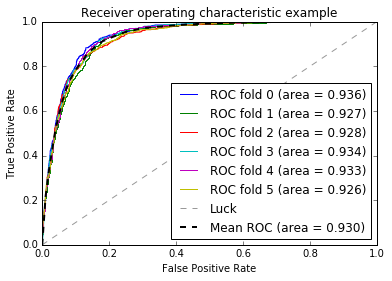

In [39]:
param = {'max_depth':6, 'eta':0.5, 'gamma': 10, 'min_child_weight': 100, 'scale_pos_weight': 2, 'silent':1, 'objective':'binary:logistic', 'eval_metric': 'auc' }
num_round = 50
evaluate_model(param, num_round)